In [1]:
!pip install keras==2.3.1
!pip install -U --pre efficientnet
import efficientnet.keras as efn 

     |████████████████████████████████| 377 kB 188 kB/s eta 0:00:01
     |████████████████████████████████| 50 kB 2.8 MB/s eta 0:00:011
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Using TensorFlow backend.


In [3]:
import tensorflow as tf
import keras
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, concatenate, Input, Lambda, Conv2D, MaxPooling2D, Reshape
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import pandas as pd
import keras.backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import os

In [4]:
batch_size = 8
def custom_generator():
    '''
    Generator for generating triplets
    '''
    triplets = pd.read_csv('../input/tripletscsv/triplets.csv').values
    np.random.shuffle(triplets)
    Q, P, N, Y = [],[],[],[]
    count = 0

    for i in range(len(triplets)):
        q = image.load_img('../input/tripletsimages/triplets_cropped/triplets_cropped/' + triplets[i][0],target_size = (300,225))
        q = image.img_to_array(q)
        q = q/255
        
        p = image.load_img('../input/tripletsimages/triplets_cropped/triplets_cropped/' + triplets[i][1],target_size = (300,225))
        p = image.img_to_array(p)
        p = p/255
        
        n = image.load_img('../input/tripletsimages/triplets_cropped/triplets_cropped/' + triplets[i][2],target_size = (300,225))
        n = image.img_to_array(n)
        n = n/255
        
        Q.append(q)
        P.append(p)
        N.append(n)
        Y.append(np.empty((4608)))
        
        count += 1
        if count == batch_size:
            yield [[np.array(Q),np.array(P),np.array(N)], np.array(Y)]
            Q, P, N, Y = [],[],[],[]
            count = 0
        

In [ ]:
gen = custom_generator()

In [ ]:
[x,y,z],k = next(gen)
print(x.shape)
print(k.shape)
fig = plt.figure(figsize = (60,60))
axes = []
c = 0
for i in range(16):
    img = x[i]
    img_2 = y[i]
    img_3 = z[i]
    axes.append(fig.add_subplot(16,3,i+1+c))
    plt.imshow(img)
    
    axes.append(fig.add_subplot(16,3,i+2+c))
    plt.imshow(img_2)
    
    axes.append(fig.add_subplot(16,3,i+3+c))
    plt.imshow(img_3)
    c += 2
plt.show()

## Model

In [5]:
def triplet_loss(y_true,y_pred,alpha = 0.3):
    '''
    Triplet loss for training
    '''
    total_length = list(y_pred.shape)[-1]
    query = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3) : int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3) : int(total_length)]
    dist_1 = K.sqrt(K.sum(K.square(query - positive),axis = 1))
    dist_2 = K.sqrt(K.sum(K.square(query - negative),axis = 1))
    
    loss = K.maximum(0.0, dist_1 - dist_2 + alpha)
    return loss
    

In [6]:
def shallow_model( x = Input((300,225,3))):
    
    x = Conv2D(filters = 32,kernel_size= (3,3),strides = 2,activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2),strides= 2)(x)
    x = Conv2D(filters = 64,kernel_size= (3,3),strides = 2,activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2),strides= 2)(x)
    x = Conv2D(filters = 64,kernel_size= (3,3),strides = 2,activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2),strides= 2)(x)
    x = Reshape((768,))(x)
    return x

In [7]:
# Defining model
base_model = efn.EfficientNetB3(weights='imagenet',include_top = False, input_shape = (300,225,3), pooling = 'max')

inp_q = Input((300,225,3))
inp_p = Input((300,225,3))
inp_n = Input((300,225,3))

l2_normalized = Lambda(lambda x : K.l2_normalize(x,axis = 1))

query_embedding = base_model(inp_q)
low_level_features_query = shallow_model(inp_q)
query_embedding = concatenate([query_embedding,low_level_features_query],axis = -1)
query_embedding = l2_normalized(query_embedding)

positive_embedding = base_model(inp_p)
low_level_features_positive = shallow_model(inp_p)
positive_embedding = concatenate([positive_embedding,low_level_features_positive],axis = -1)
positive_embedding = l2_normalized(positive_embedding)

negative_embedding = base_model(inp_n)
low_level_features_negative = shallow_model(inp_n)
negative_embedding = concatenate([negative_embedding,low_level_features_negative],axis = -1)
negative_embedding = l2_normalized(negative_embedding)

merged_layer = concatenate([query_embedding,positive_embedding,negative_embedding],axis = -1)


model = Model([inp_q,inp_p,inp_n],merged_layer)
#lr_schedule = schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps = 5348,decay_rate = 0.7,staircase = True)
opt = Adam(learning_rate = 1e-3 , amsgrad = True)
model.compile(loss = triplet_loss, optimizer = opt)
model.summary()


44113920/44107200 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 225, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 300, 225, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 300, 225, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 112, 32) 896         input_3[0][0]                    
___________________________

In [8]:
triplets = pd.read_csv('../input/tripletscsv/triplets.csv')

In [ ]:
gen = custom_generator()
STEP_SIZE_TRAIN = len(triplets)//8

model.fit_generator(
                    gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=2,
                    verbose=1
                    )
#model.save('/kaggle/working/epoch_1_normalized_pooling_max_low_features.h5')

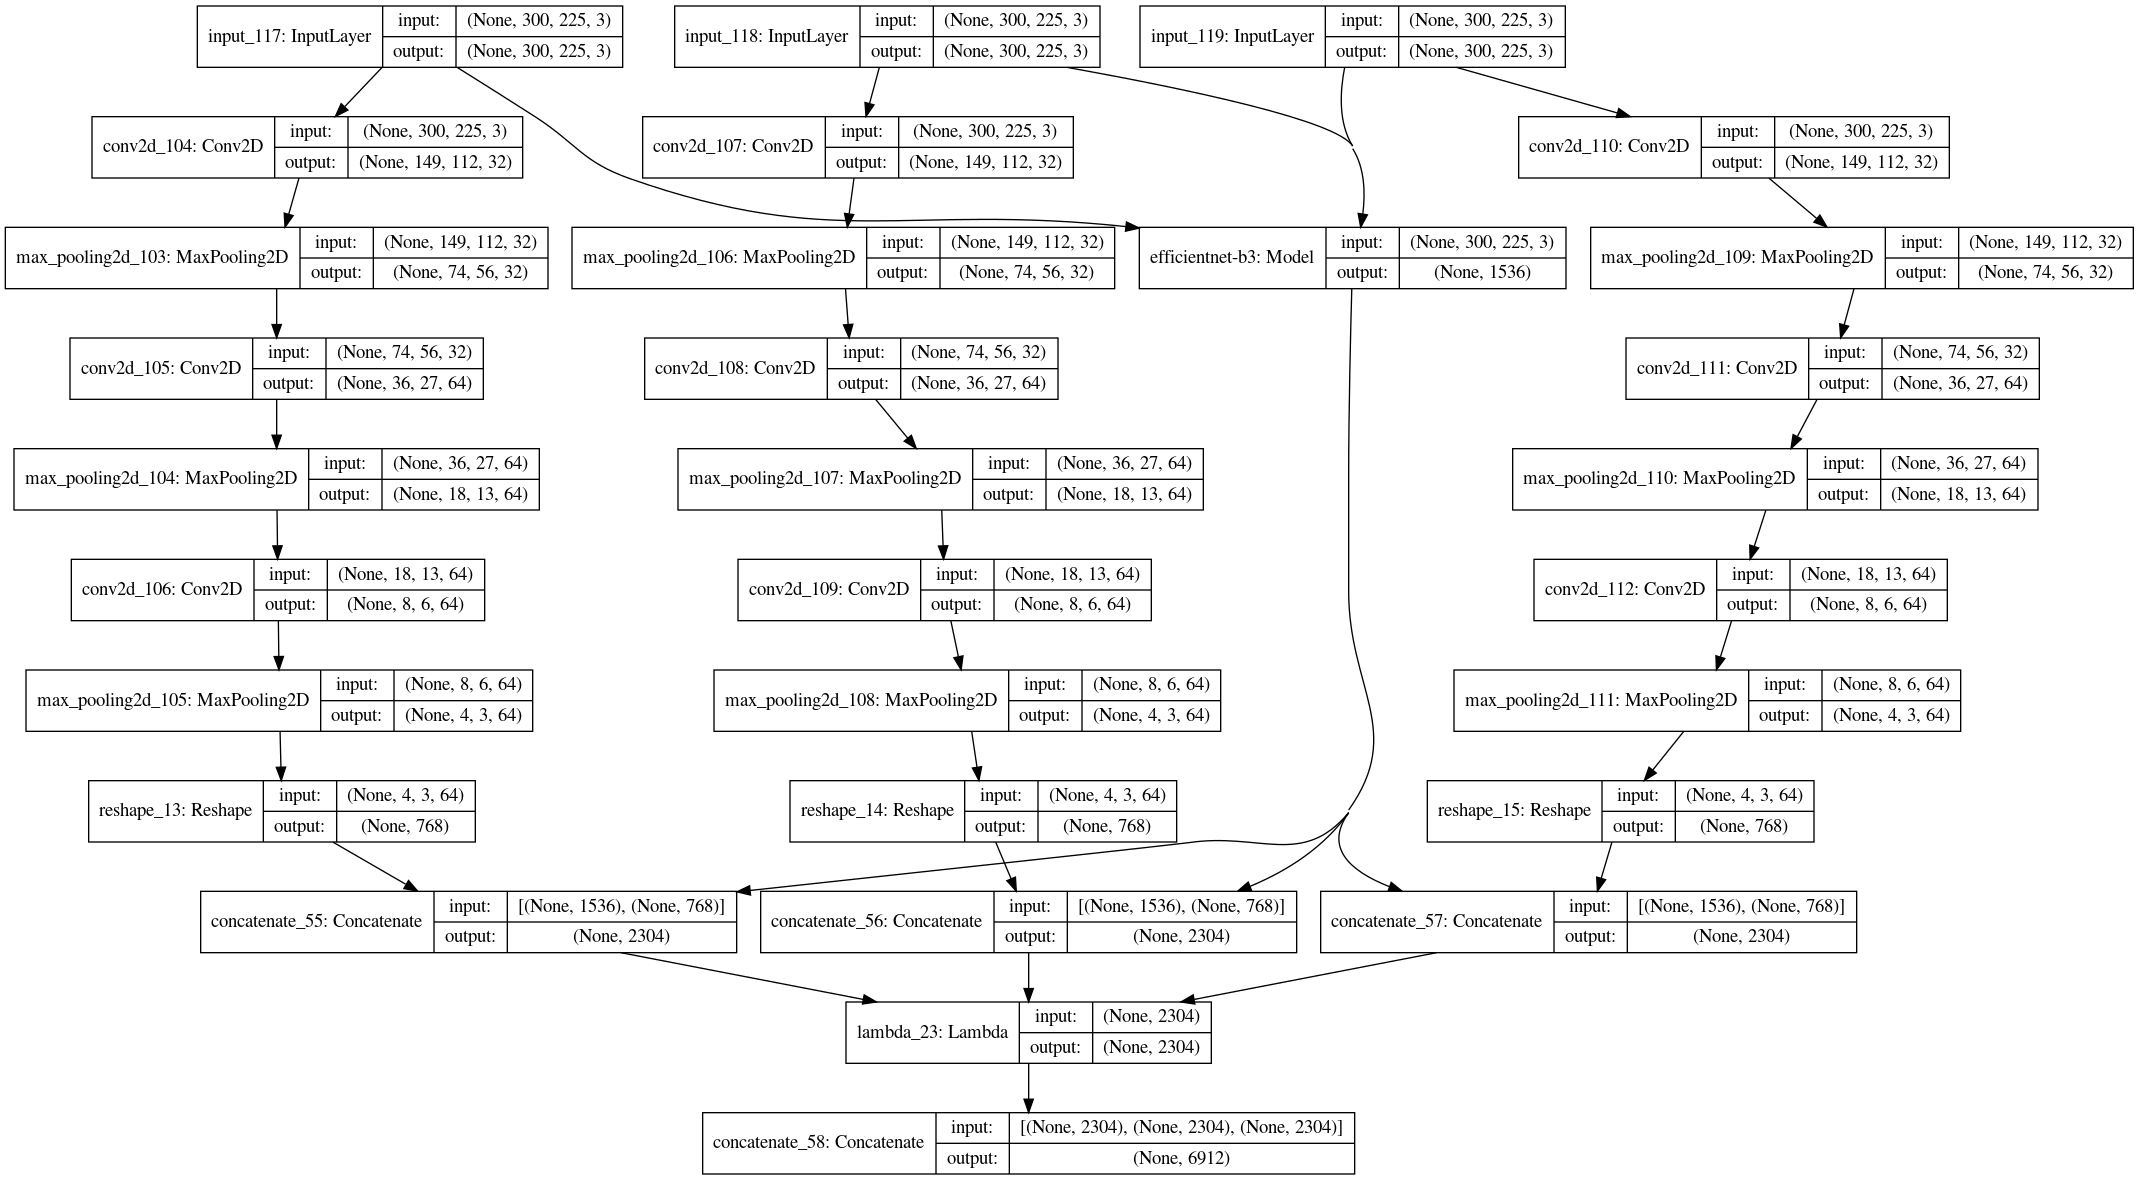

In [54]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [84]:
model2 = Model(inp_q,query_embedding)
model2.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_125 (InputLayer)          (None, 300, 225, 3)  0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 149, 112, 32) 896         input_125[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_121 (MaxPooling2D (None, 74, 56, 32)   0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 36, 27, 64)   18496       max_pooling2d_121[0][0]          
___________________________________________________________________________________________

In [112]:
embedding_matrix = []
for file in os.listdir('../input/test-dataset-triplets/my_dataset'):
    img = image.load_img('../input/test-dataset-triplets/my_dataset/' + file,target_size = (300,225))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis = 0)
    embedding = model2.predict(img)
    embedding_matrix.append((file,embedding))
    
embedding_matrix = np.array(embedding_matrix)
embedding_matrix = np.squeeze(embedding_matrix)


[['13.jpeg', 0.0], ['4.jpg', 0.11433467], ['12.jpg', 0.11447047], ['10.jpg', 0.11496218], ['9.jpeg', 0.116965406]]


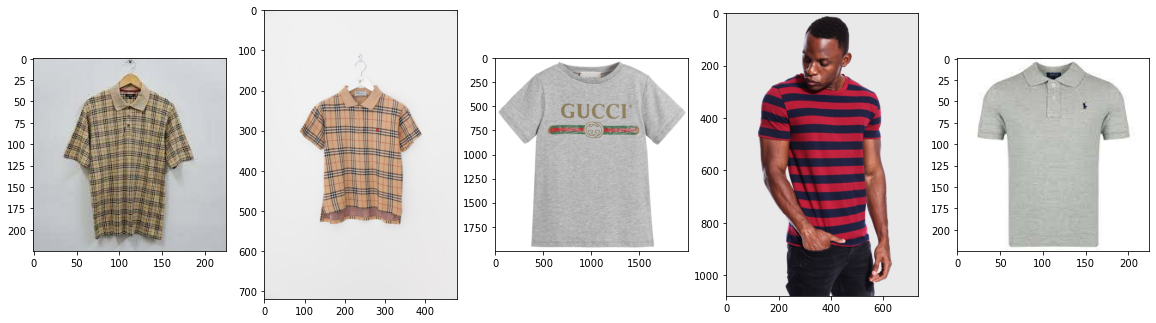

In [113]:
def distance(a,b):
    return np.sqrt(np.sum((a-b)**2))

sample_image = image.load_img('../input/test-dataset-triplets/my_dataset/13.jpeg',target_size = (300,225))
sample_image = image.img_to_array(sample_image)
sample_image = sample_image/255
sample_image = np.expand_dims(sample_image,axis = 0)
sample_embedding = model2.predict(sample_image)
sample_embedding = np.squeeze(sample_embedding)

d = []
for i in range(len(embedding_matrix)):
    d.append([embedding_matrix[i][0],distance(sample_embedding,embedding_matrix[i][1][0])])

d = sorted(d,key = lambda x:x[1])[:5]

print(d)
axes = []
fig = plt.figure(figsize = (20,20))
for i in range(5):
    axes.append(fig.add_subplot(1,5,i+1))
    img = image.load_img('../input/test-dataset-triplets/my_dataset/' + d[i][0])
    img = image.img_to_array(img)
    plt.imshow(img/255)
    
    
plt.show()    